<a href="https://colab.research.google.com/github/paruliansaragi/cnn-fastai/blob/master/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install fastai

In [0]:
!unzip PASCAL_VOC.zip

Archive:  PASCAL_VOC.zip
   creating: PASCAL_VOC/
  inflating: PASCAL_VOC/pascal_test2007.json  
  inflating: PASCAL_VOC/pascal_train2007.json  
  inflating: PASCAL_VOC/pascal_train2012.json  
  inflating: PASCAL_VOC/pascal_val2007.json  
  inflating: PASCAL_VOC/pascal_val2012.json  


A generator is something you can iterate over.

We will be looking at the Pascal VOC dataset. It's quite slow, so you may prefer to download from this mirror. There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we are using the python 3 standard library pathlib for our paths and file access. Note that it returns an OS-specific class (on Linux, PosixPath) so your output may look a little different. Most libraries than take paths as input can take a pathlib object - although some (like cv2) can't, in which case you can use str() to convert it to a string.

In [0]:
!tar -xvf VOCtrainval_06-Nov-2007.tar


VOCdevkit/
VOCdevkit/VOC2007/
VOCdevkit/VOC2007/Annotations/
VOCdevkit/VOC2007/Annotations/000005.xml
VOCdevkit/VOC2007/Annotations/000007.xml
VOCdevkit/VOC2007/Annotations/000009.xml
VOCdevkit/VOC2007/Annotations/000012.xml
VOCdevkit/VOC2007/Annotations/000016.xml
VOCdevkit/VOC2007/Annotations/000017.xml
VOCdevkit/VOC2007/Annotations/000019.xml
VOCdevkit/VOC2007/Annotations/000020.xml
VOCdevkit/VOC2007/Annotations/000021.xml
VOCdevkit/VOC2007/Annotations/000023.xml
VOCdevkit/VOC2007/Annotations/000024.xml
VOCdevkit/VOC2007/Annotations/000026.xml
VOCdevkit/VOC2007/Annotations/000030.xml
VOCdevkit/VOC2007/Annotations/000032.xml
VOCdevkit/VOC2007/Annotations/000033.xml
VOCdevkit/VOC2007/Annotations/000034.xml
VOCdevkit/VOC2007/Annotations/000035.xml
VOCdevkit/VOC2007/Annotations/000036.xml
VOCdevkit/VOC2007/Annotations/000039.xml
VOCdevkit/VOC2007/Annotations/000041.xml
VOCdevkit/VOC2007/Annotations/000042.xml
VOCdevkit/VOC2007/Annotations/000044.xml
VOCdevkit/VOC2007/Annotations/000046.

In [0]:
!unzip pascal-voc-2007.zip

Archive:  pascal-voc-2007.zip
replace PASCAL_VOC.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: PASCAL_VOC.zip          
replace VOCtrainval_06-Nov-2007.tar? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: VOCtrainval_06-Nov-2007.tar  
replace VOCtest_06-Nov-2007.tar? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: VOCtest_06-Nov-2007.tar  y
y
y



In [0]:
import os

os.makedirs('data/pascal', exist_ok=True)

In [0]:
!mv PASCAL_VOC data/pascal

In [0]:
PATH = Path('data/pascal')
list(PATH.iterdir())

In [0]:
!kaggle datasets download -d zaraks/pascal-voc-2007

100% 839M/839M [00:12<00:00, 77.7MB/s]
100% 839M/839M [00:12<00:00, 70.4MB/s]


In [0]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects


In [0]:
PATH = Path('.')

In [0]:
trn_j = json.load((PATH/'PASCAL_VOC/pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [0]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']

In [0]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = JPEGS

In [0]:
len(cats)

20

In [0]:
len(trn_fns)

2501

In [0]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt, verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [0]:
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1] + 1, a[2] - a[0] + 1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16, 8))
    for b, c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH + trn_fns[i])
    draw_im(im, im_a)

In [0]:
f_model = resnet34
sz=224
bs=64

In [0]:
TMP_PATH = "/tmp/tmp"
MODEL_PATH = "/tmp/model/"

In [0]:
!mkdir {TMP_PATH}

In [0]:
MC_CSV = Path(TMP_PATH + '/lrg.csv')

In [0]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [0]:
mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

In [0]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn', 'clas'])
df.to_csv(MC_CSV, index=False)

In [0]:
tfms=tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms, bs=bs)

In [0]:
learn = ConvLearner.pretrained(f_model, md, tmp_name=TMP_PATH, models_name=MODEL_PATH)
learn.opt_fn = optim.Adam

In [0]:
lrf = learn.lr_find(1e-5, 100)

 91%|█████████ | 29/32 [00:21<00:00,  3.47it/s, loss=2.87]

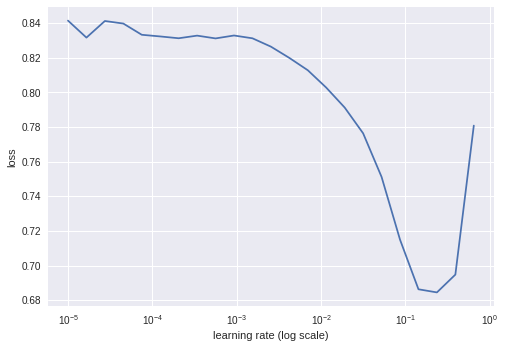

In [0]:
learn.sched.plot(0)

In [0]:
lr = 2e-2
learn.fit(lr, 1, cycle_len=3, use_clr=(32, 5))

epoch      trn_loss   val_loss   <lambda>   
    0      0.329467   0.129919   0.9548    
    1      0.174344   0.080395   0.9746    
    2      0.116996   0.074857   0.9742    


[array([0.07486]), 0.9741999955177307]

In [0]:
lrs= np.array([lr/100, lr/10, lr])
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:22<00:02,  1.78it/s, loss=0.417]

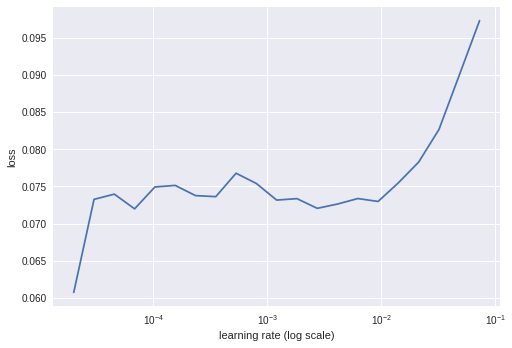

In [0]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [0]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32, 5))

epoch      trn_loss   val_loss   <lambda>   
    0      0.073519   0.077629   0.9748    
    1      0.054467   0.082596   0.9728    
    2      0.039762   0.075943   0.9746    
    3      0.028263   0.076608   0.9766    
    4      0.020329   0.077915   0.976     


[array([0.07792]), 0.9759999928474427]

In [0]:
learn.save('mclas')

In [0]:
learn.load('mclas')

In [0]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)

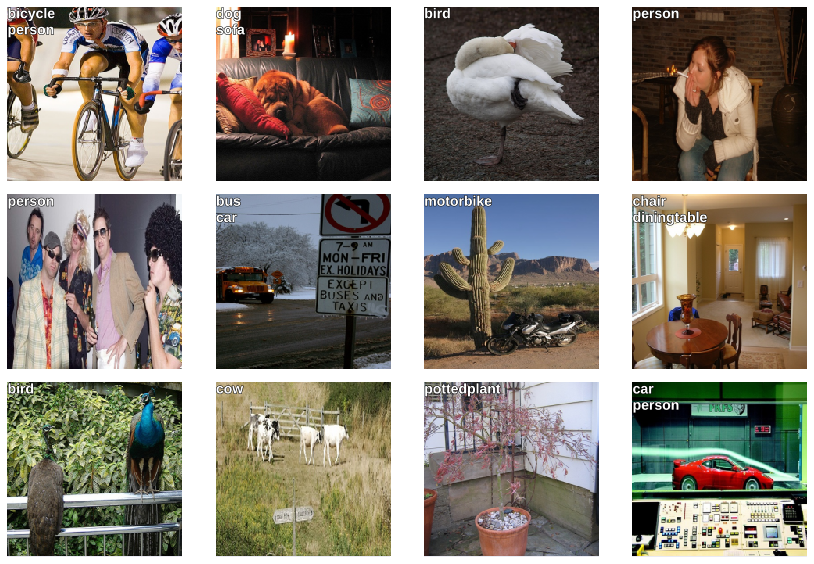

In [0]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i]>0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

In [0]:
CLAS_CSV = Path(TMP_PATH + '/clas.csv')
MBB_CSV = Path(TMP_PATH + '/mbb.csv')

f_model = resnet34
sz=224
bs=64

In [0]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k, v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]);mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [0]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs),) = split_by_idx(val_idxs, mcs)

In [0]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn', 'bbox'])
df.to_csv(MBB_CSV, index=False)

In [0]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
           RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
           RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)

In [0]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [0]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1, 4)]
    if prs is None: prs = [None]*len(bb)
    if clas is None: clas= [None]*len(bb)
    ax = show_img(im, ax=ax)
    for im , (b, c, pr) in enumerate(zip(bb, clas, prs)):
        if ((b[2]>0) and (pr is None or pr>thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [0]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds, self.y2 = ds, y2
        self.sz = ds.sz
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

In [0]:
trn_ds2= ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [0]:
x, y = to_np(next(iter(md.val_dl)))
x = md.val_ds.ds.denorm(x)

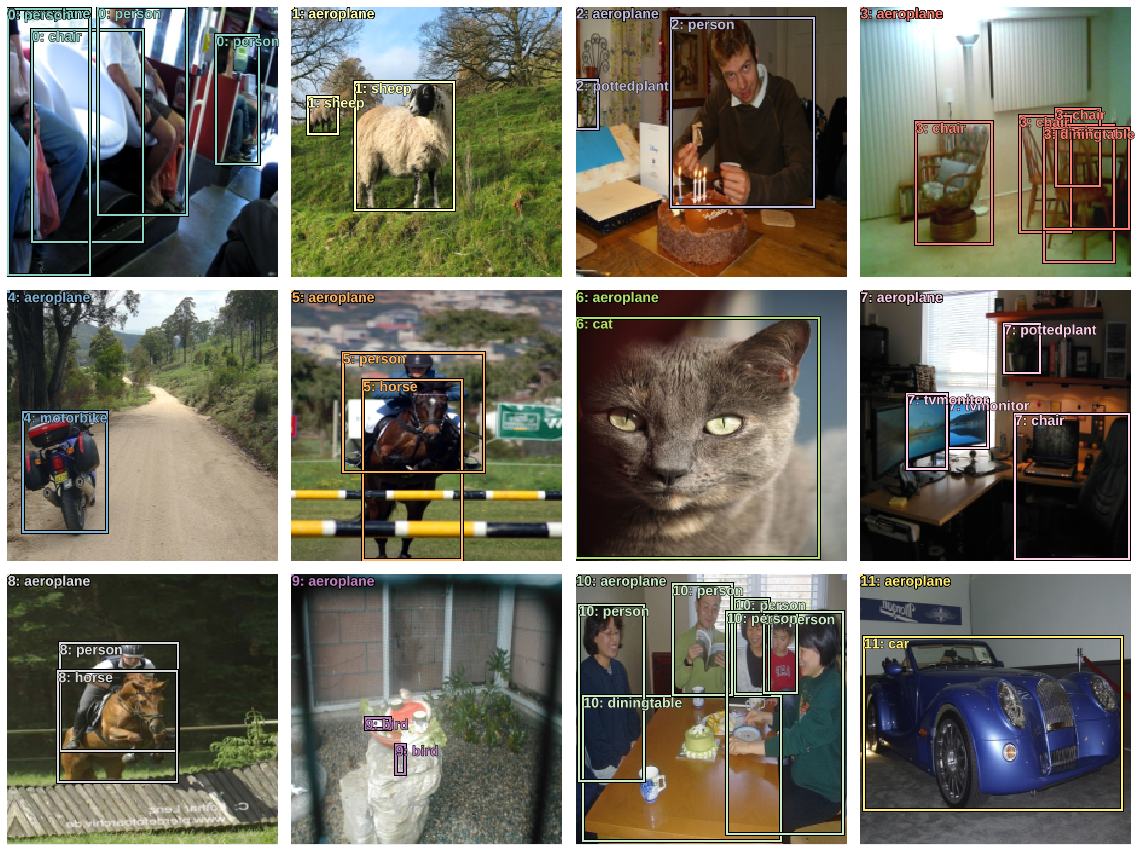

In [0]:
x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

In [0]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis=1), (k, 1))
anc_sizes = np.array([[1/anc_grid, 1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

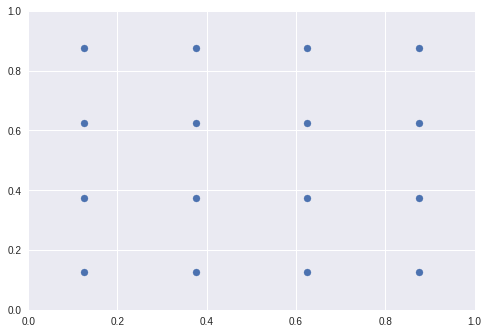

In [0]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0,1 );

In [0]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [0]:
n_clas = len(id2cat) + 1
n_cat = k*(4+n_clas)

class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
    
    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))

def flatten_conv(x, k):
    bs, nf, gx, gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf//k)

In [0]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [0]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)

head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models, tmp_name=TMP_PATH, models_name=MODEL_PATH)
learn.opt_fn = optim.Adam

In [0]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [0]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [0]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

In [0]:
def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [0]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [0]:
batch = learn.model(x)

In [0]:
ssd_loss(batch, y, True)


 0.1947
 0.1168
 0.2652
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.2885
 0.0888
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.9027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.1608
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3237
 0.2153
 0.2558
 0.2013
 0.2526
 0.0485
 0.0879
[torch.cuda.FloatTensor of size 7 (GPU 0)]


 0.3258
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2704
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3985
 0.4538
 0.1897
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.1527
 0.1863
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3426
 0.3249
 0.5062
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.0642
 0.2506
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.2027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2418
 0.2337
 0.2590
[torch.cuda.FloatTensor of size 3 (GPU 0)]


1.00000e-02 *
  8.4642
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3652
 0.1377
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.5146
  5.739

Variable containing:
 84.0434
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [0]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

epoch      trn_loss   val_loss   
    0      94.923213  32374.683875


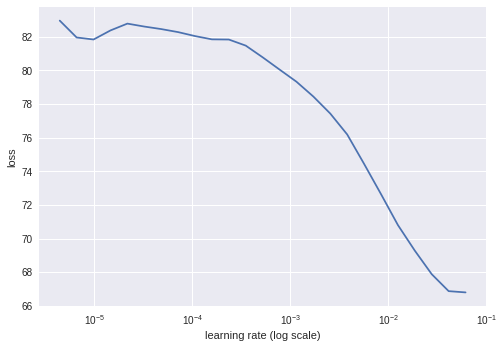

In [0]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [0]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

epoch      trn_loss   val_loss   
    0      43.041547  32.006545 
    1      33.565029  27.780832 
    2      29.329338  26.89981  
    3      26.528722  26.179508 
    4      24.296149  25.713348 


[array([25.71335])]

In [0]:
learn.save('0')

In [0]:
learn.load('0')

In [0]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [0]:
b_clas.size(),b_bb.size()
idx=7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

(Variable containing:
  0.6786  0.4866  0.9911  0.6250
  0.7098  0.0848  0.9911  0.5491
  0.5134  0.8304  0.6696  0.9063
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)], Variable containing:
   8
  10
  17
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [0]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

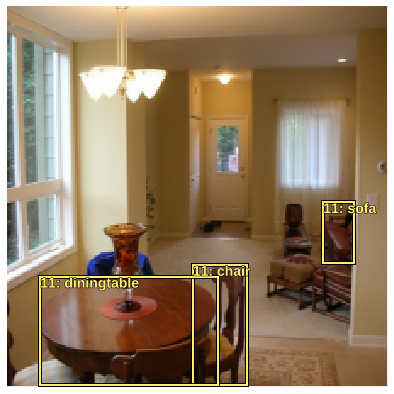

In [0]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

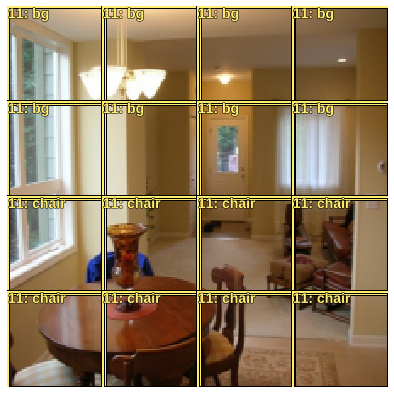

In [0]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

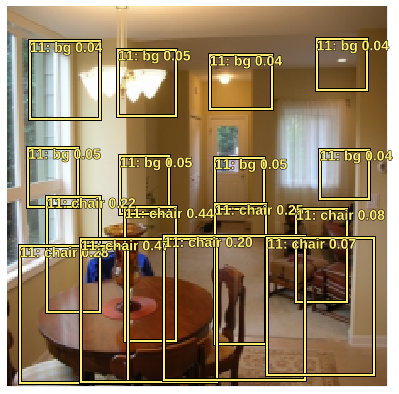

In [0]:
a_ic = actn_to_bb(b_bboxi, anchors)
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)
overlaps = jaccard(bbox.data, anchor_cnr.data)

In [0]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)

In [0]:
gt_clas = clas[gt_idx]; gt_clas

Variable containing:
  8
  8
  8
  8
  8
  8
  8
  8
 10
 10
  8
 17
 10
 10
  8
  8
[torch.cuda.LongTensor of size 16 (GPU 0)]